Extension upon **Language Is Not All You Need: Aligning Perception with Language Models**

An extension upon the KOSMOS model made by Microsoft AI Research. The model is being adapted to be fine-tuned through the implementation of a Low-rank adaptation(LoRA) to the attention layers in the text and vision models. The goal of this extension is to enable fine tuning with lower computational costs. Different placements of the LoRA (keys, values, or query) as well as different choices or R and alpha provided different results.

# Requirements

In [ ]:
!pip install datasets
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from transformers import AutoProcessor, AutoModelForVision2Seq, get_linear_schedule_with_warmup
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
from transformers import Kosmos2ForConditionalGeneration, Kosmos2Config

import requests
from PIL import Image as PImage
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
import math
import requests
import numpy as np
from tqdm import tqdm
import seaborn as sns
import re
import os
import json
from collections import defaultdict
import random


In [ ]:
!pip freeze > requirements.txt

# Preparing the Model

In [ ]:
# check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
# model training was done on using a google colab pro subscribtion

Using device: cuda


In [ ]:
## Smaller Config of Kosmos2 for testing
configuration = Kosmos2Config(
      text_config = {"layers" : 4},
      vision_config = {"num_hidden_layers" : 4}
)


In [ ]:
torch.cuda.empty_cache()

# model = CustomKosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224").to(device) # uncomment for smaller module
model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224").to(device) # full-sized module
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")

model

config.json:   0%|          | 0.00/4.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/191k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Kosmos2ForConditionalGeneration(
  (text_model): Kosmos2TextForCausalLM(
    (model): Kosmos2TextTransformer(
      (embed_tokens): Embedding(65037, 2048, padding_idx=1)
      (embed_positions): Kosmos2TextSinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-23): 24 x Kosmos2TextBlock(
          (self_attn): KosmosTextAttention(
            (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (inner_attn_ln): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          )
          (self_attn_layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (ffn): Kosmos2TextFFN(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=2048, out_features=8192, bias=True)
   

# Preparing the Dataset

Preparing the dataset. For this demonstration, the model will be fine-tuned on a benchmark dataset of bird images. This way, the multimodality can be effectively tested.

In [ ]:
ds = load_dataset("dpdl-benchmark/caltech_birds2011")

README.md:   0%|          | 0.00/588 [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

test-00000-of-00004.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

test-00001-of-00004.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

test-00002-of-00004.parquet:   0%|          | 0.00/411M [00:00<?, ?B/s]

test-00003-of-00004.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5994 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5794 [00:00<?, ? examples/s]

In [ ]:
def fix_label(input_label):
  input_label = input_label.replace("_", " ")
  input_label = input_label.split("'")[1]
  return input_label

In [ ]:
class CustomImageTextDataset(Dataset):
    def __init__(self, dataset, processor):
        self.images = dataset
        self.processor = processor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]["image"]
        prompt = "<grounding>What breed of bird is in this image? Answer: "
        label =  "<grounding>What breed of bird is in this image? Answer: " + fix_label(self.images[idx]["label_name"])
        label = self.processor(text=label, return_tensors="pt")
        inputs = self.processor(text=prompt, images=image, return_tensors="pt")
        label = label["input_ids"]
        # label = inputs["input_ids"] # fix for length
        return {
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'image_embeds_position_mask': inputs['image_embeds_position_mask'].squeeze(0),
            'label': label.squeeze(0)
        }
def collate_fn(batch):
    # making sure that the tensor lengths match bc if they don't everyone is sad
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    image_embeds_position_mask = [item['image_embeds_position_mask'] for item in batch]
    labels = [item['label'] for item in batch]
    max_length = max(len(ids) for ids in input_ids)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    image_embeds_position_mask = pad_sequence(image_embeds_position_mask, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=0)

    if input_ids.size(1) != labels.size(1):
        padding_size = abs(input_ids.size(1) - labels.size(1))
        if input_ids.size(1) > labels.size(1):
            labels = torch.nn.functional.pad(labels, (0, padding_size), value=0)
        else:
            input_ids = torch.nn.functional.pad(input_ids, (0, padding_size), value=0)
            attention_mask = torch.nn.functional.pad(attention_mask, (0, padding_size), value=0)
            image_embeds_position_mask = torch.nn.functional.pad(image_embeds_position_mask, (0, padding_size), value=0)
    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'image_embeds_position_mask': image_embeds_position_mask,
        'labels': labels
    }

dataset = CustomImageTextDataset(ds["train"], processor)
train_dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

test_dataset = CustomImageTextDataset(ds["test"], processor)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)  # Increase batch_size if memory allows


In [ ]:
sample_input = {k: v.to(device) for k, v in iter(train_dataloader).__next__().items()}
print(sample_input["pixel_values"].shape)
print(sample_input["input_ids"].shape)
print(sample_input["attention_mask"].shape)
print(sample_input["image_embeds_position_mask"].shape)
print(sample_input["labels"].shape)

torch.Size([2, 3, 224, 224])
torch.Size([2, 79])
torch.Size([2, 79])
torch.Size([2, 79])
torch.Size([2, 79])


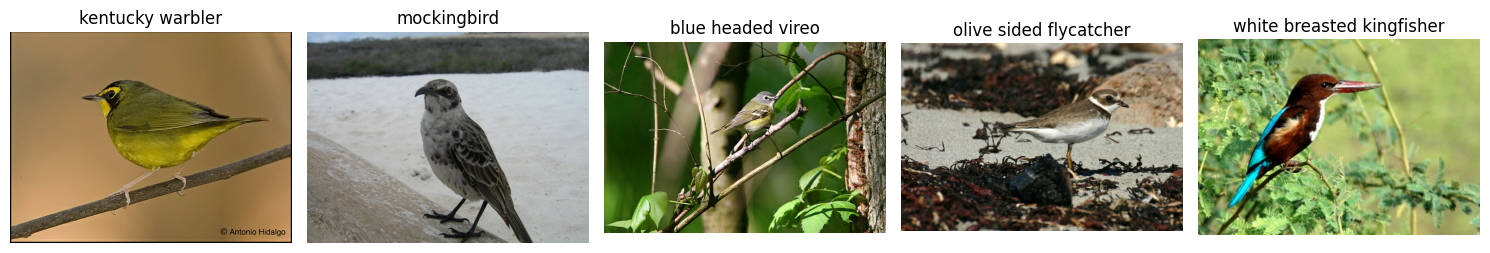

In [ ]:
num_displayed = 5
images = ds["test"][0:num_displayed]['image']
captions = ds["test"][0:num_displayed]['label_name']

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for ax, img, caption in zip(axes, images, captions):
    ax.imshow(img)
    ax.set_title(fix_label(caption))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# data statistics
print(ds["test"])
print(ds["train"])

Dataset({
    features: ['image', 'image/filename', 'label', 'label_name', 'bbox', 'segmentation_mask'],
    num_rows: 5794
})
Dataset({
    features: ['image', 'image/filename', 'label', 'label_name', 'bbox', 'segmentation_mask'],
    num_rows: 5994
})


In [ ]:
# example input tensor shape through processor
import requests

prompt = "<grounding>An image of"
url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png"
image = PImage.open(requests.get(url, stream=True).raw)

inputs = processor(text=prompt, images=image, return_tensors="pt")
inputs.keys()

dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'image_embeds_position_mask'])

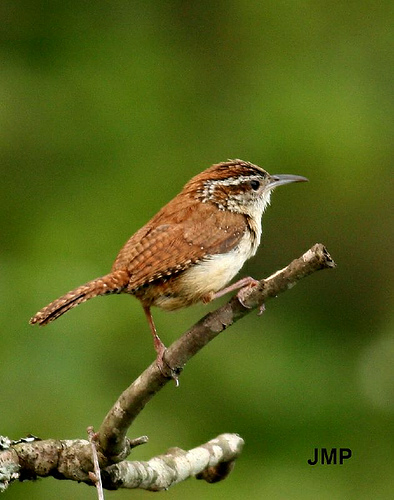

Bird type: kentucky warbler
What breed of bird is in this image? Answer: The image features a small brown bird with a long tail.


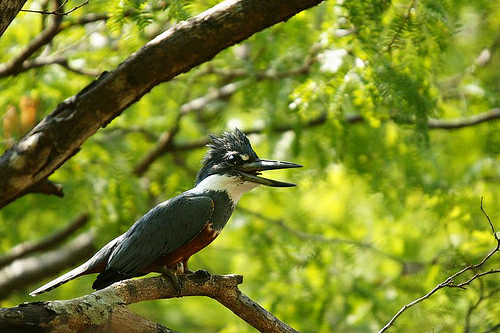

Bird type: mockingbird
What breed of bird is in this image? Answer: A black-crowned night heron is in the image. The black-crested night-heron is a large wading bird native to South and Central America.


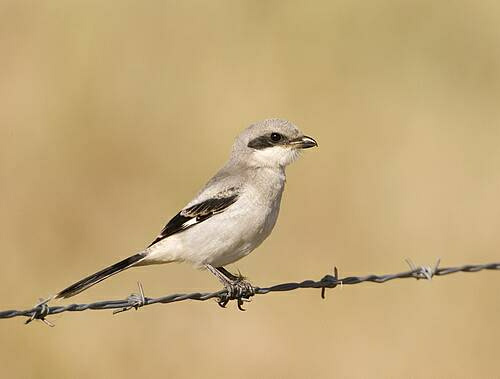

Bird type: blue headed vireo
What breed of bird is in this image? Answer: A northern shrike is in the image.


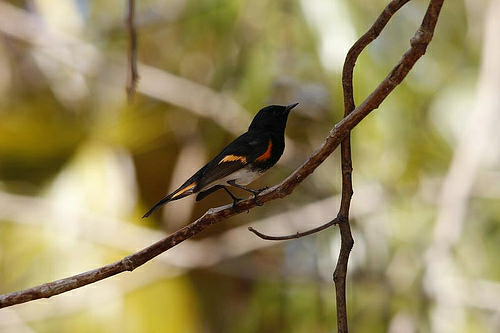

Bird type: olive sided flycatcher
What breed of bird is in this image? Answer: The image features a small black bird with orange and white feathers.


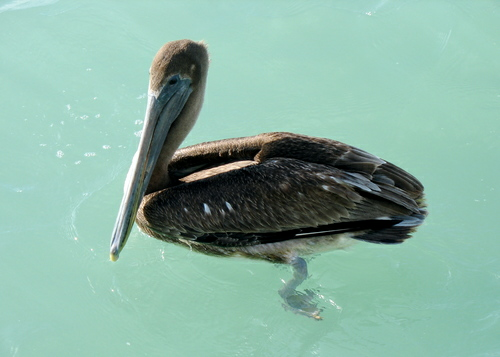

Bird type: white breasted kingfisher
What breed of bird is in this image? Answer: The image features a brown pelican. The brown pelican is a large water bird with a long neck and a long beak.


In [ ]:
# example of model output before fine-tuning
prompt = "<grounding>What breed of bird is in this image? Answer:"
tests_attempted = 5

for i in range(tests_attempted):
    image = ds["test"][i*37+10*random.randint(1, 10)]['image']
    display(image)
    print("Bird type: " + fix_label(ds["test"][i]['label_name']))

    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = inputs.to(device)

    generated_ids = model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=128,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text, entities = processor.post_process_generation(generated_text)
    print(processed_text)

In [ ]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
processed_text, entities = processor.post_process_generation(generated_text)
print(generated_text)

<image>. the, to and of as in I that' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> What breed of bird is in this image? Answer:<phrase> A kingfisher</phrase><object><patch_index_0163><patch_index_0885></object> is in the image.


# Implementing LoRA

In [ ]:
class LoRA(nn.Module):
    def __init__(self, rank, alpha, weight):
        super().__init__()
        self.in_features = weight.shape[0]
        self.out_features = weight.shape[1]
        self.rank = rank
        self.alpha = alpha

        self.weight = nn.Parameter(weight.clone(), requires_grad=False)

        self.lora_A = nn.Linear(self.in_features, self.rank, bias=False)
        self.lora_B = nn.Linear(self.rank, self.out_features, bias=False)

        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)

        self.scale = alpha / rank

    def forward(self, x):
        base_output = F.linear(x, self.weight)
        lora_output = self.lora_B(self.lora_A(x)) * self.scale
        return base_output + lora_output # residual connection!

def apply_lora_to_model(model, lora_rank, lora_alpha):
    for param in model.parameters():
        param.requires_grad = False
    for i in range(len(model.text_model.model.layers)): # text model
        layer = model.text_model.model.layers[i].self_attn

        original_q_proj = layer.q_proj
        layer.q_proj = LoRA(
            lora_rank,
            lora_alpha,
            original_q_proj.weight
        ).to(original_q_proj.weight.device)

        original_v_proj = layer.v_proj
        layer.v_proj = LoRA(
            lora_rank,
            lora_alpha,
            original_v_proj.weight
        ).to(original_v_proj.weight.device)

    for i in range(len(model.vision_model.model.encoder.layers)): # vision model
        layer = model.vision_model.model.encoder.layers[i].self_attn

        original_q_proj = layer.q_proj
        layer.q_proj = LoRA(
            lora_rank,
            lora_alpha,
            original_q_proj.weight
        ).to(original_q_proj.weight.device)

        original_v_proj = layer.v_proj
        layer.v_proj = LoRA(
            lora_rank,
            lora_alpha,
            original_v_proj.weight
        ).to(original_v_proj.weight.device)

    return model

def get_lora_parameters(model):
    lora_params = []

    for layer in model.text_model.model.layers:
        if hasattr(layer.self_attn.q_proj, 'lora_A'):
            lora_params.extend([
                *layer.self_attn.q_proj.lora_A.parameters(),
                *layer.self_attn.q_proj.lora_B.parameters()
            ])
        if hasattr(layer.self_attn.v_proj, 'lora_A'):
            lora_params.extend([
                *layer.self_attn.v_proj.lora_A.parameters(),
                *layer.self_attn.v_proj.lora_B.parameters()
            ])

    for layer in model.vision_model.model.encoder.layers:
        if hasattr(layer.self_attn.q_proj, 'lora_A'):
            lora_params.extend([
                *layer.self_attn.q_proj.lora_A.parameters(),
                *layer.self_attn.q_proj.lora_B.parameters()
            ])
        if hasattr(layer.self_attn.v_proj, 'lora_A'):
            lora_params.extend([
                *layer.self_attn.v_proj.lora_A.parameters(),
                *layer.self_attn.v_proj.lora_B.parameters()
            ])

    return lora_params

In [ ]:
def save_lora_weights(model, save_path="lora_weights.pth"):
    lora_state_dict = {}

    for name, layer in model.named_modules():
        if isinstance(layer, LoRA):
            lora_state_dict[f"{name}.lora_A.weight"] = layer.lora_A.weight.detach().cpu()
            lora_state_dict[f"{name}.lora_B.weight"] = layer.lora_B.weight.detach().cpu()

    torch.save(lora_state_dict, save_path)
    print(f"LoRA weights saved to {save_path}")

In [ ]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def print_hierarchy(layers, indent=""):
    for layer_name, layer_info in layers.items():
        if isinstance(layer_info, dict):
            print(f"{indent}{layer_name}/")
            print_hierarchy(layer_info, indent + "    ")
        else:
            print(f"{indent}{layer_name}: {layer_info} trainable params")

def get_layer_hierarchy(model):
    layers = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            names = name.split(".")
            current = layers
            for part in names[:-1]:
                current = current.setdefault(part, {})
            current[names[-1]] = param.numel()
    return layers

In [ ]:
trainable_params = count_trainable_parameters(model)
print(f"Number of trainable parameters before LoRA: {trainable_params}")

Number of trainable parameters before LoRA: 1664485376


In [ ]:
# APPLY THE LoRA here!
lora_rank = 4
lora_alpha = 16

lora_model = apply_lora_to_model(model, lora_rank, lora_alpha)

lora_parameters = get_lora_parameters(lora_model)

optimizer = torch.optim.AdamW(lora_parameters, lr=5e-5)

In [ ]:
def load_lora_weights(model, load_path="lora_weights.pth"):
    lora_state_dict = torch.load(load_path)

    for name, layer in model.named_modules():
        if isinstance(layer, LoRA) and f"{name}.lora_A.weight" in lora_state_dict:
            layer.lora_A.weight.data = lora_state_dict[f"{name}.lora_A.weight"].to(layer.lora_A.weight.device)
            layer.lora_B.weight.data = lora_state_dict[f"{name}.lora_B.weight"].to(layer.lora_B.weight.device)

    print(f"LoRA weights loaded from {load_path}")

if os.path.exists("lora_weights.pth"):
    load_lora_weights(lora_model, "lora_weights.pth")

In [ ]:
trainable_params = count_trainable_parameters(lora_model)
print(f"Number of trainable parameters after LoRA: {trainable_params}")

Number of trainable parameters after LoRA: 1179648


In [ ]:
# showing new architecture with LoRA connections
lora_model

Kosmos2ForConditionalGeneration(
  (text_model): Kosmos2TextForCausalLM(
    (model): Kosmos2TextTransformer(
      (embed_tokens): Embedding(65037, 2048, padding_idx=1)
      (embed_positions): Kosmos2TextSinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-23): 24 x Kosmos2TextBlock(
          (self_attn): KosmosTextAttention(
            (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (v_proj): LoRA(
              (lora_A): Linear(in_features=2048, out_features=4, bias=False)
              (lora_B): Linear(in_features=4, out_features=2048, bias=False)
            )
            (q_proj): LoRA(
              (lora_A): Linear(in_features=2048, out_features=4, bias=False)
              (lora_B): Linear(in_features=4, out_features=2048, bias=False)
            )
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (inner_attn_ln): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          )
       

In [ ]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0.01
)

In [ ]:
def visualize_training_stats(all_losses, batch_size, save_path=None, show_plot=True):
    plt.style.use('seaborn-v0_8-paper')
    sns.set_palette("deep")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[2, 1])

    steps = np.arange(len(all_losses))
    epochs = steps * batch_size / len(steps)

    ax1.plot(epochs, all_losses, 'lightgray', alpha=0.3, label='Raw Loss')

    window_size = min(100, len(all_losses) // 10)
    moving_avg = np.convolve(all_losses, np.ones(window_size)/window_size, mode='valid')
    moving_avg_epochs = epochs[window_size-1:]
    ax1.plot(moving_avg_epochs, moving_avg, linewidth=2, label='Moving Average')

    min_loss_idx = np.argmin(moving_avg)
    ax1.scatter(moving_avg_epochs[min_loss_idx], moving_avg[min_loss_idx],
                color='red', s=100, zorder=5, label=f'Min Loss: {moving_avg[min_loss_idx]:.4f}')

    ax1.set_xlabel('Step (x1000)')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.7)

    sns.histplot(all_losses, bins=50, ax=ax2, kde=True)
    ax2.set_xlabel('Loss Value')
    ax2.set_ylabel('Frequency')

    stats_text = f'Statistics:\nMean: {np.mean(all_losses):.4f}\nStd: {np.std(all_losses):.4f}\n' \
                 f'Min: {np.min(all_losses):.4f}\nMax: {np.max(all_losses):.4f}'
    ax2.text(0.95, 0.95, stats_text,
             transform=ax2.transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    if show_plot:
        plt.show()
    else:
        plt.close()


# Test Loss Before Tuning

In [ ]:
def evaluate_kosmos(model, test_dataloader, device="cuda"):
    model.eval()
    all_test_losses = []
    with torch.no_grad():
        progress_bar = tqdm(test_dataloader, desc="Evaluating")

        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            image_embeds_position_mask = batch["image_embeds_position_mask"].to(device)
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                image_embeds=None,
                image_embeds_position_mask=image_embeds_position_mask
            )
            loss = outputs.loss
            all_test_losses.append(loss.item())
            progress_bar.set_postfix({'test_loss': f"{np.mean(all_test_losses):.4f}"})

    avg_test_loss = np.mean(all_test_losses)
    print(f"Average Testing Loss: {avg_test_loss:.4f}")
    return avg_test_loss, all_test_losses


In [ ]:
avg_test_loss1, test_loss_history1 = evaluate_kosmos(model, test_dataloader, device=device)


Evaluating: 100%|██████████| 1449/1449 [04:58<00:00,  4.86it/s, test_loss=11.9536]

Average Testing Loss: 11.9536


# Fine-tuning

In [ ]:
def train_kosmos(model, train_dataloader, num_epochs=3, device="cuda"):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_training_steps = len(train_dataloader) * num_epochs
    num_warmup_steps = num_training_steps // 10
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )
    global_step = 0
    model.train()

    all_losses = []

    for epoch in range(num_epochs):
        epoch_loss = []
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            image_embeds_position_mask=batch["image_embeds_position_mask"].to(device)

            optimizer.zero_grad()

            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                image_embeds=None,
                image_embeds_position_mask=image_embeds_position_mask
            )

            loss = outputs.loss
            current_loss = loss.item()
            epoch_loss.append(current_loss)
            all_losses.append(current_loss)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({
                'current_loss': f"{loss.item():.4f}",
                'avg_loss': f"{np.mean(epoch_loss):.4f}"
            })
            global_step += 1

        avg_epoch_loss = np.mean(epoch_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {avg_epoch_loss:.4f}")
        save_lora_weights(model, save_path=f"lora_weights{epoch+1}.pth")
    with open("loss_history.json", "w") as f:
        json.dump(all_losses, f)
    return model, all_losses

if __name__ == "__main__":
    trained_model, loss_history = train_kosmos(
        model=lora_model,
        train_dataloader=train_dataloader,
        num_epochs=4,
        device=device
    )



Epoch 1/4: 100%|██████████| 2997/2997 [10:10<00:00,  4.91it/s, current_loss=0.1517, avg_loss=1.8821]


Epoch 1/4 - Average Loss: 1.8821
LoRA weights saved to lora_weights1.pth


Epoch 2/4: 100%|██████████| 2997/2997 [10:08<00:00,  4.93it/s, current_loss=0.1142, avg_loss=0.2509]


Epoch 2/4 - Average Loss: 0.2509
LoRA weights saved to lora_weights2.pth


Epoch 3/4: 100%|██████████| 2997/2997 [10:13<00:00,  4.89it/s, current_loss=0.2850, avg_loss=0.2132]


Epoch 3/4 - Average Loss: 0.2132
LoRA weights saved to lora_weights3.pth


Epoch 4/4: 100%|██████████| 2997/2997 [10:08<00:00,  4.92it/s, current_loss=0.1818, avg_loss=0.1943]

Epoch 4/4 - Average Loss: 0.1943
LoRA weights saved to lora_weights4.pth


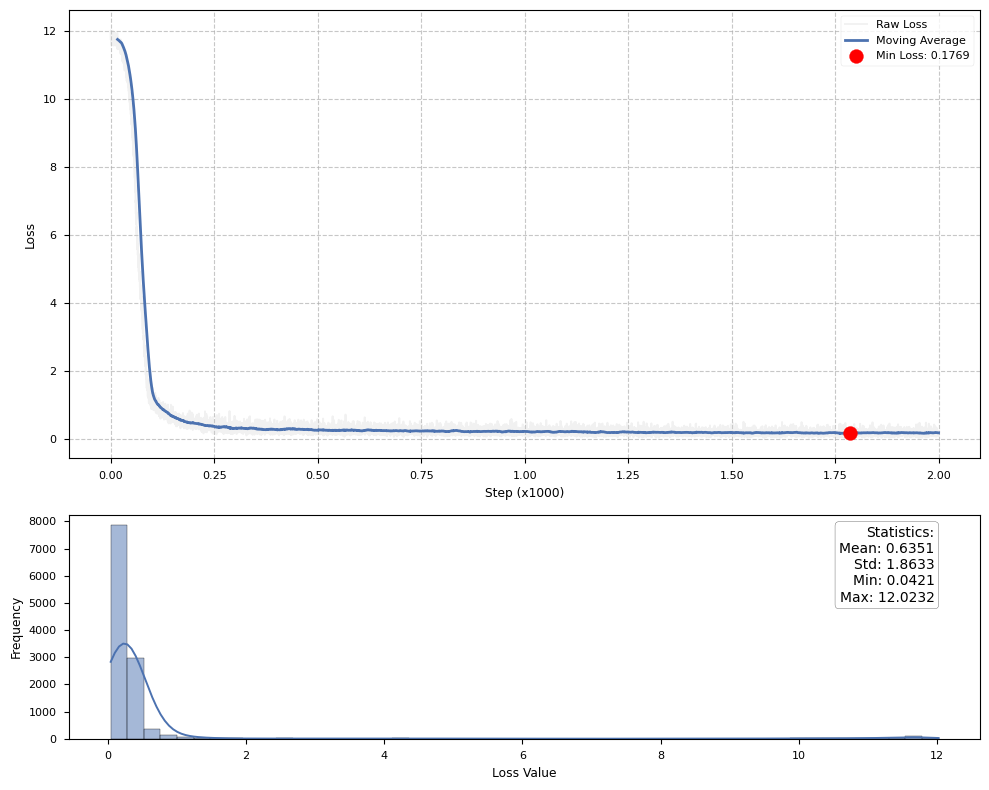

In [ ]:
visualize_training_stats(
      all_losses=loss_history,
      batch_size=train_dataloader.batch_size,
      save_path='training_stats.pdf'
  )

# Results

In [ ]:
avg_test_loss2, test_loss_history2 = evaluate_kosmos(lora_model, test_dataloader, device=device)


Evaluating: 100%|██████████| 1449/1449 [04:57<00:00,  4.88it/s, test_loss=0.1623]

Average Testing Loss: 0.1623


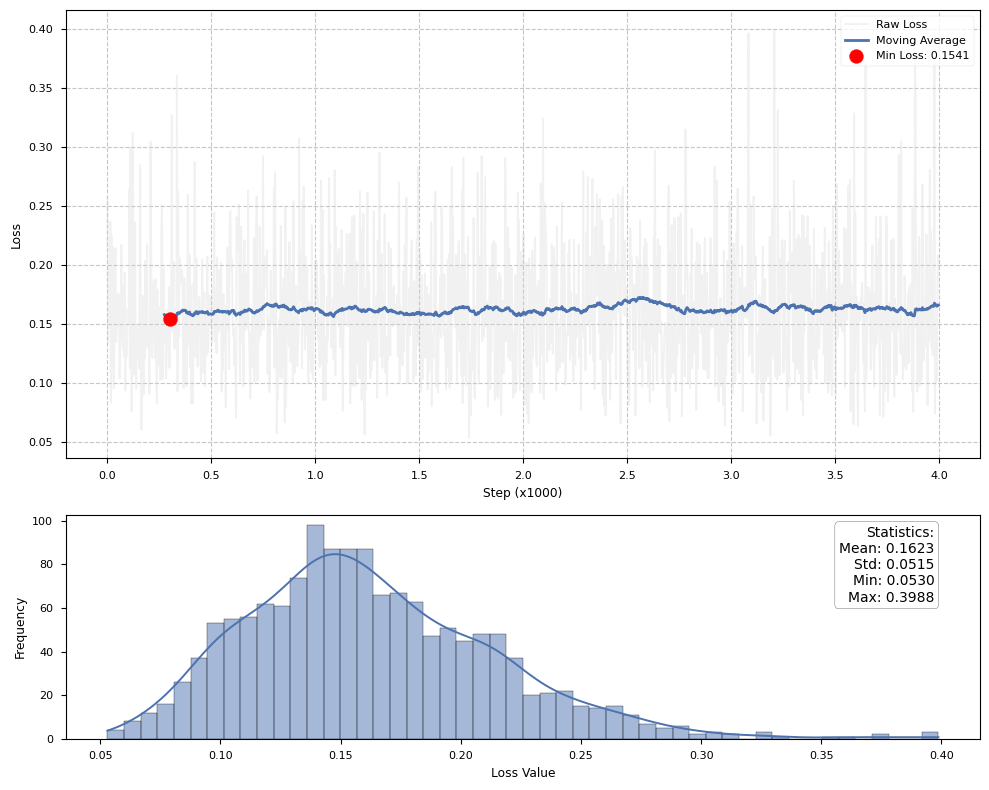

In [ ]:
visualize_training_stats(
      all_losses=test_loss_history2,
      batch_size=test_dataloader.batch_size,
      save_path='test_stats.pdf'
  )

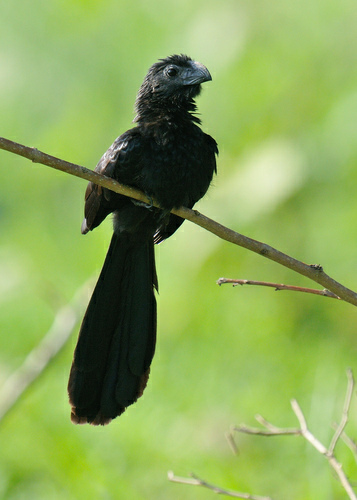

Bird type: kentucky warbler
What breed of bird is in this image? Answer: The image features a black bird, specifically a crow, perched on a tree branch.


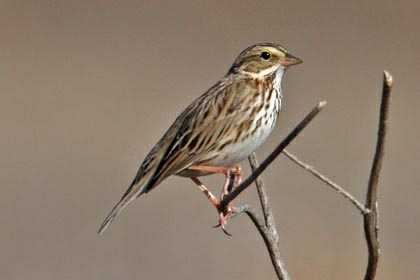

Bird type: mockingbird
What breed of bird is in this image? Answer: The bird in this image is a Savannah Sparrow.


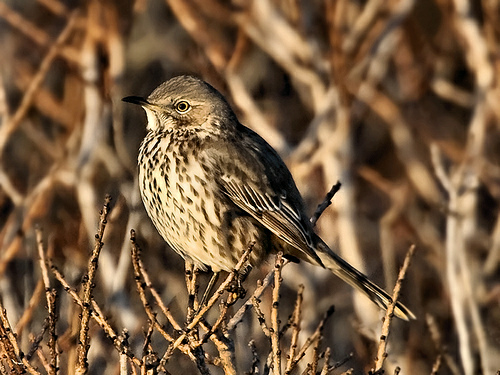

Bird type: blue headed vireo
What breed of bird is in this image? Answer: The bird in this image is a small brown bird.


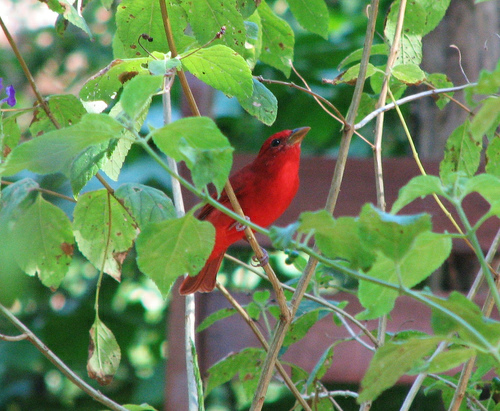

Bird type: olive sided flycatcher
What breed of bird is in this image? Answer: The image features a red bird. The bird is perched on a branch, surrounded by leaves.


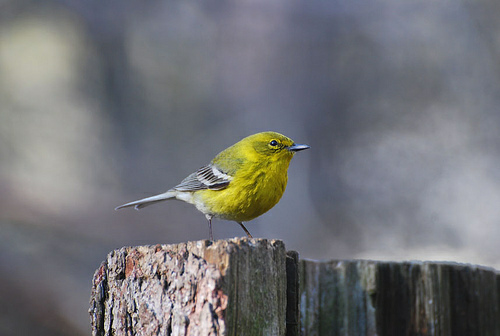

Bird type: white breasted kingfisher
What breed of bird is in this image? Answer: A yellow warbler is in the image.


In [ ]:
# example of model output after fine-tuning
prompt = "<grounding>What breed of bird is in this image? Answer:"
tests_attempted = 5

for i in range(tests_attempted):
    image = ds["test"][i*37+10*random.randint(1, 10)]['image']
    display(image)
    print("Bird type: " + fix_label(ds["test"][i]['label_name']))

    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = inputs.to(device)

    generated_ids = model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=128,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text, entities = processor.post_process_generation(generated_text)
    print(processed_text)